In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import brentq



In [45]:
def tunnel_volume(h: float) -> float:
    """
    Compute tunnel volume [m³] as a function of water level h [m].

    Piecewise definition from HSY spec:
      - 0   ≤ h ≤ 0.4   : constant 350 m³
      - 0.4 < h ≤ 6.0   : V = (((1000 * (h - 0.4)**2) / 2) * 5) + 350
      - 6.0 < h ≤ 8.7   : V = (5500 * (h - 5.9) * 5) + 75975
      - 8.7 < h ≤ 14.1  : V = (((5.5 * 5500 / 2)
                                - ((5.5 - (h - 8.6))**2 * 1000 / 2)) * 5) \
                               + 150225
    """
    if h < 0:
        raise ValueError("Water level h cannot be negative")

    # 0 – 0.4 m
    if h <= 0.4:
        return 350.0

    # 0.4 – 6 m
    if h <= 6.0:
        return (((1000.0 * (h - 0.4)**2) / 2.0) * 5.0) + 350.0

    # 6 – 8.7 m
    if h <= 8.7:
        return (5500.0 * (h - 5.9) * 5.0) + 75975.0

    # 8.7 – 14.1 m
    if h <= 14.1:
        return (((5.5 * 5500.0 / 2.0)
                 - ((5.5 - (h - 8.6))**2 * 1000.0 / 2.0)) * 5.0) + 150225.0

    # Above design range
    raise ValueError("Water level h exceeds model range (h > 14.1 m)")

In [46]:
def tunnel_height_from_volume(V):
    """
    Numerically invert tunnel_volume(h) to solve for h.
    Assumes V is within the valid range of the function.
    """
    # Define root function
    f = lambda h: tunnel_volume(h) - V
    
    # Solve on known domain
    h = brentq(f, 0.0, 14.1)
    return h

In [47]:
tunnel_height_from_volume(10000)

2.36468827043885

In [48]:
# Read data in Hackathon_HSY_data.xlsx

df = pd.read_excel('Hackathon_HSY_data.xlsx', header=0, skiprows=[1])


df.keys()

Index(['Time stamp', 'Water level in tunnel L2', 'Water volume in tunnel V',
       'Sum of pumped flow to WWTP F2', 'Inflow to tunnel F1', 'Pump flow 1.1',
       'Pump flow 1.2', 'Pump flow 1.3', 'Pump flow 1.4', 'Pump flow 2.1',
       'Pump flow 2.2', 'Pump flow 2.3', 'Pump flow 2.4',
       'Pump efficiency 1.1', 'Pump efficiency 1.2', 'Pump efficiency 1.3',
       'Pump efficiency 1.4', 'Pump efficiency 2.1', 'Pump efficiency 2.2',
       'Pump efficiency 2.3', 'Pump efficiency 2.4', 'Pump frequency 1.1',
       'Pump frequency 1.2', 'Pump frequency 1.3', 'Pump frequency 1.4',
       'Pump frequency 2.1', 'Pump frequency 2.2', 'Pump frequency 2.3',
       'Pump frequency 2.4', 'Electricity price 1: high',
       'Electricity price 2: normal'],
      dtype='object')

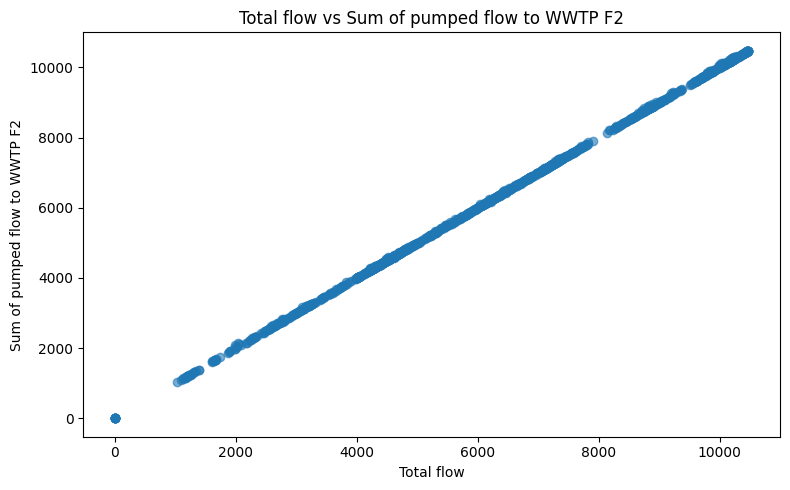

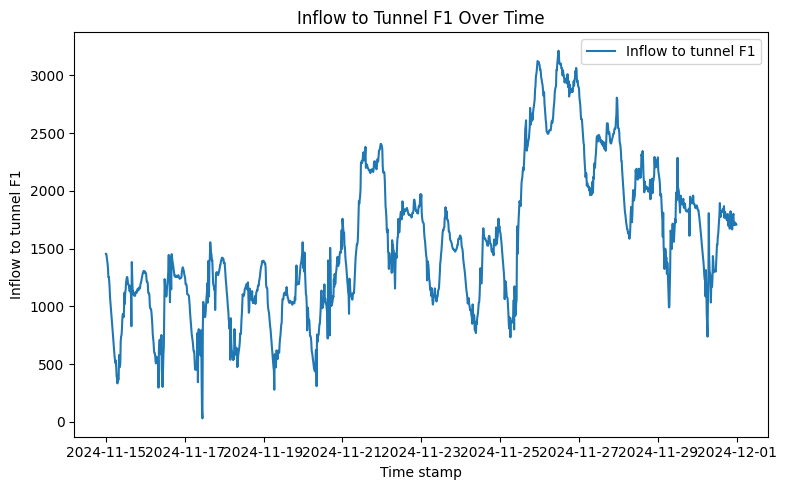

In [49]:
efficiency_columns = [
    'Pump efficiency 1.1', 'Pump efficiency 1.2', 'Pump efficiency 1.3',
    'Pump efficiency 1.4', 'Pump efficiency 2.1', 'Pump efficiency 2.2',
    'Pump efficiency 2.3', 'Pump efficiency 2.4'
]
df['Total Effect'] = df[efficiency_columns].sum(axis=1)

flow_columns = [
    'Pump flow 1.1', 'Pump flow 1.2', 'Pump flow 1.3', 'Pump flow 1.4',
    'Pump flow 2.1', 'Pump flow 2.2', 'Pump flow 2.3', 'Pump flow 2.4'
]
df['Total flow'] = df[flow_columns].sum(axis=1)


plt.figure(figsize=(8, 5))
plt.scatter(df['Total flow'], df['Sum of pumped flow to WWTP F2'], alpha=0.6)
plt.title('Total flow vs Sum of pumped flow to WWTP F2')
plt.xlabel('Total flow')
plt.ylabel('Sum of pumped flow to WWTP F2')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(df['Time stamp'], df['Inflow to tunnel F1'], label='Inflow to tunnel F1')
plt.title('Inflow to Tunnel F1 Over Time')
plt.xlabel('Time stamp')
plt.ylabel('Inflow to tunnel F1')
plt.legend()
plt.tight_layout()
plt.show()




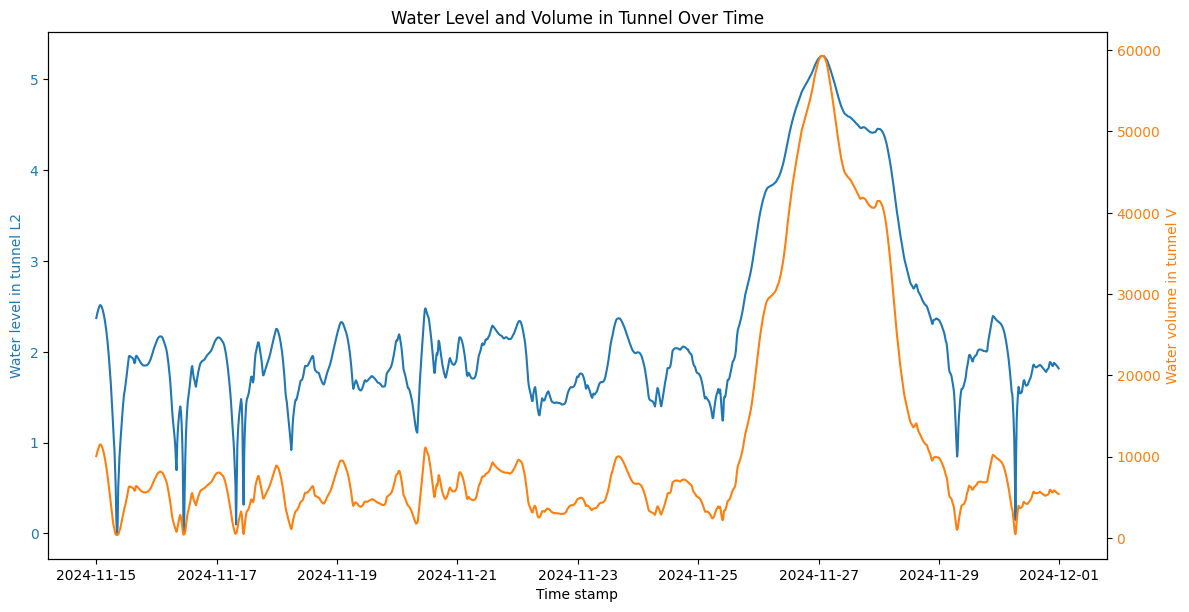

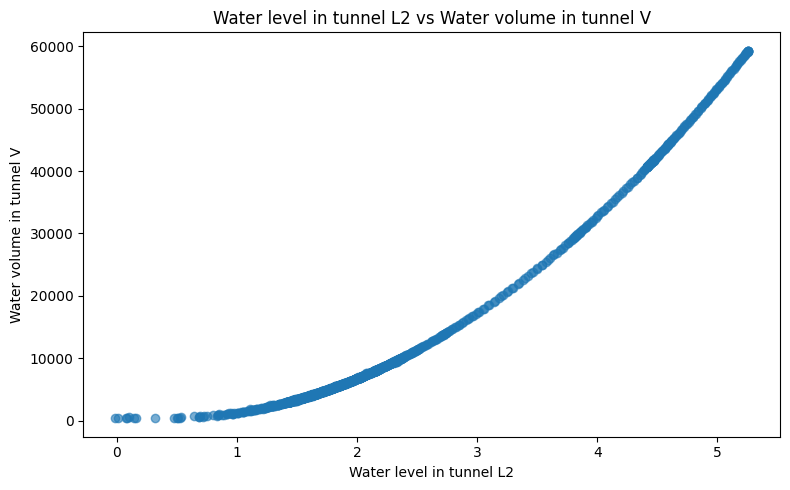

In [50]:
fig, ax1 = plt.subplots(figsize=(12, 6))

color1 = 'tab:blue'
ax1.set_xlabel('Time stamp')
ax1.set_ylabel('Water level in tunnel L2', color=color1)
ax1.plot(df['Time stamp'], df['Water level in tunnel L2'], color=color1, label='Water level in tunnel L2')
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
color2 = 'tab:orange'
ax2.set_ylabel('Water volume in tunnel V', color=color2)
ax2.plot(df['Time stamp'], df['Water volume in tunnel V'], color=color2, label='Water volume in tunnel V')
ax2.tick_params(axis='y', labelcolor=color2)

fig.tight_layout()
plt.title("Water Level and Volume in Tunnel Over Time")
plt.show()


# Scatter plot: Water level in tunnel L2 vs Water volume in tunnel V
plt.figure(figsize=(8, 5))
plt.scatter(df['Water level in tunnel L2'], df['Water volume in tunnel V'], alpha=0.6)
plt.title('Water level in tunnel L2 vs Water volume in tunnel V')
plt.xlabel('Water level in tunnel L2')
plt.ylabel('Water volume in tunnel V')
plt.tight_layout()
plt.show()


<Axes: >

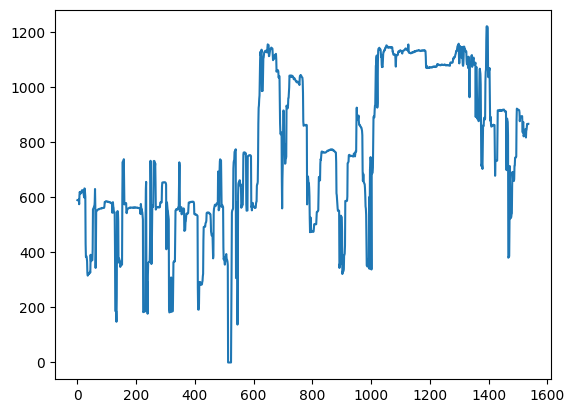

In [51]:
df['Total Effect'].plot()

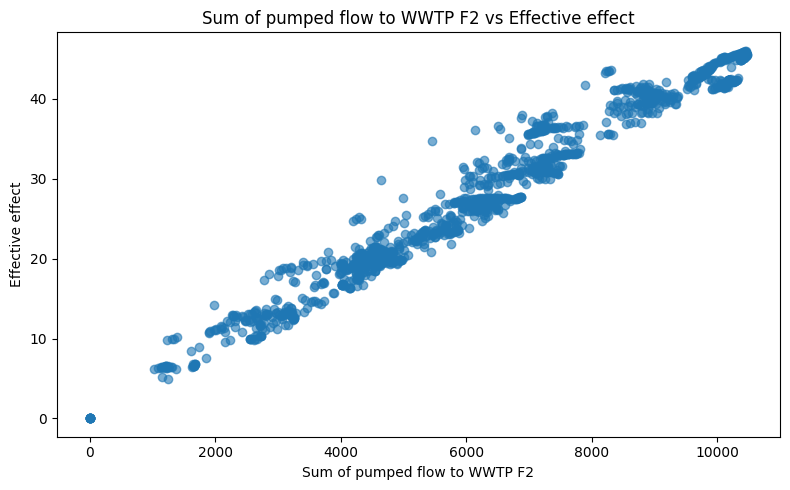

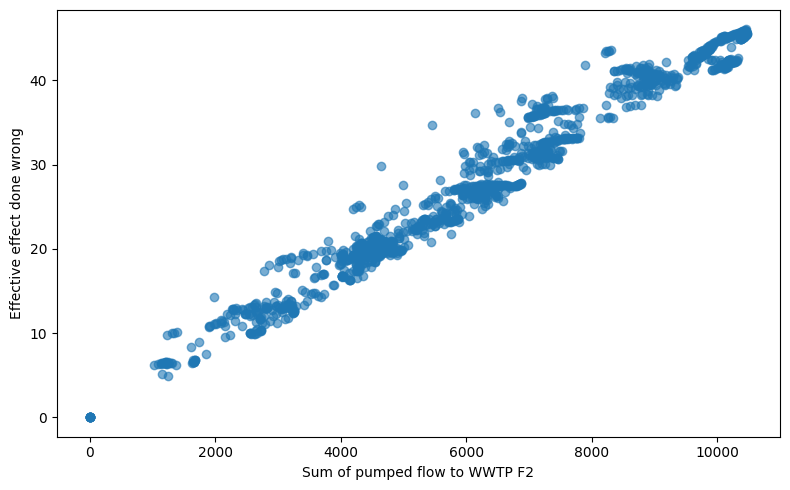

In [52]:
df['Effective effect'] = df['Total Effect'] / (30 - df['Water level in tunnel L2'])
plt.figure(figsize=(8, 5))
plt.scatter(df['Sum of pumped flow to WWTP F2'], df['Effective effect'], alpha=0.6)
plt.title('Sum of pumped flow to WWTP F2 vs Effective effect')
plt.xlabel('Sum of pumped flow to WWTP F2')
plt.ylabel('Effective effect')
plt.tight_layout()
plt.show()

df['Effective effect done wrong'] = df['Total Effect'] / (30 - df['Water level in tunnel L2'])
plt.figure(figsize=(8, 5))
plt.scatter(df['Sum of pumped flow to WWTP F2'], df['Effective effect done wrong'], alpha=0.6)
# plt.title('Sum of pumped flow to WWTP F2 vs Effective effect done wrong')
plt.xlabel('Sum of pumped flow to WWTP F2')
plt.ylabel('Effective effect done wrong')
plt.tight_layout()
plt.show()

Pump flow 1.1


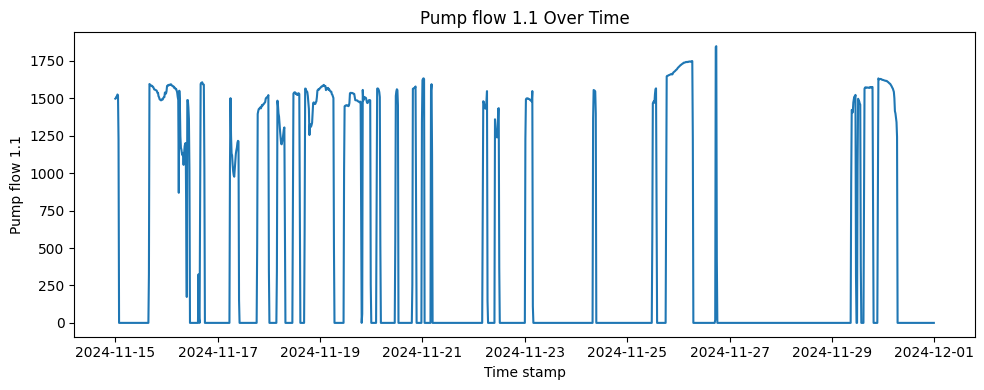

Pump flow 1.2


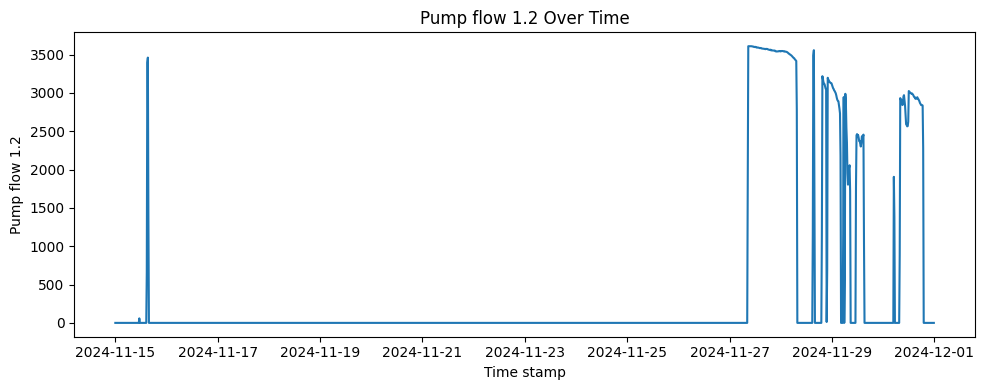

Pump flow 1.3


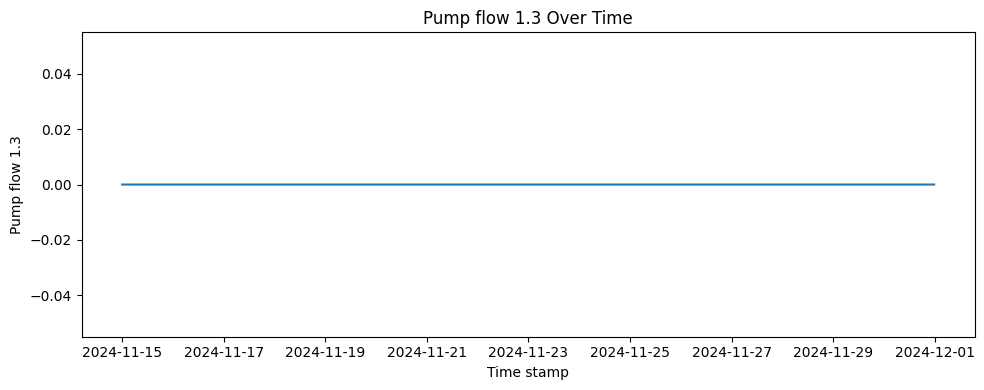

Pump flow 1.4


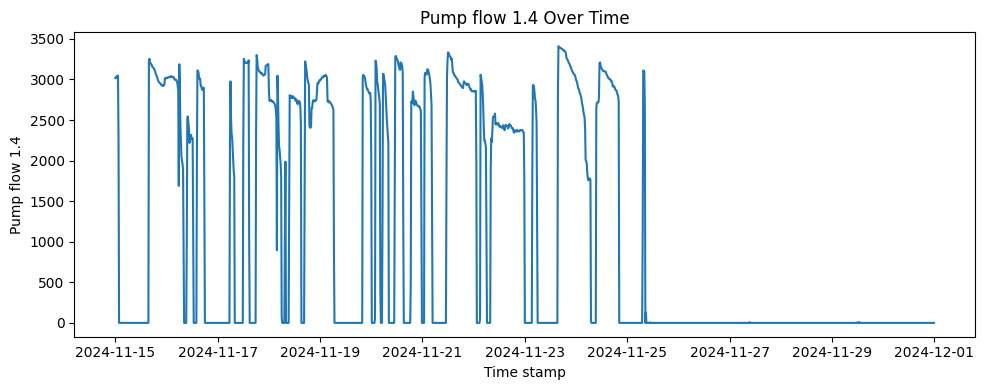

Pump flow 2.1


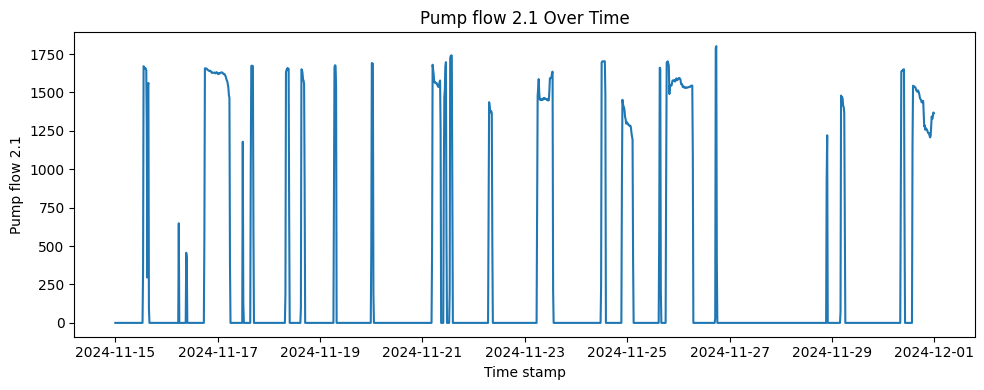

Pump flow 2.2


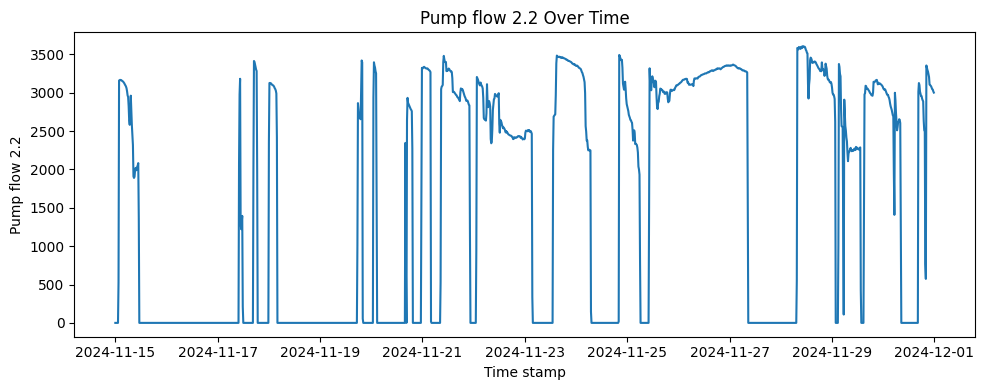

Pump flow 2.3


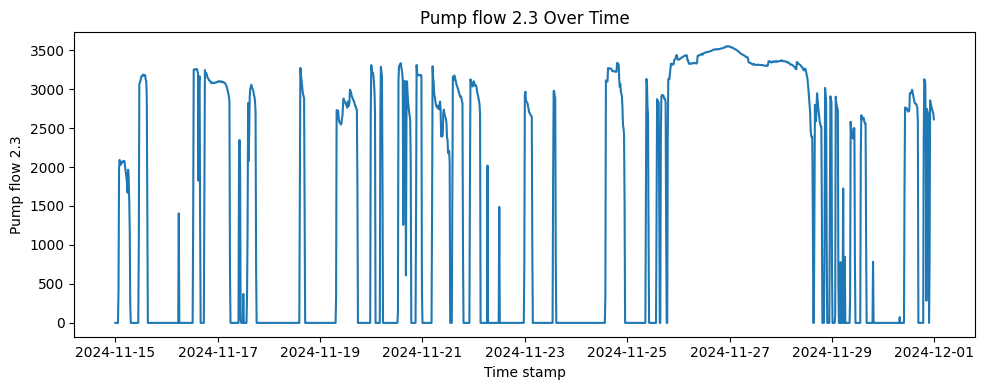

Pump flow 2.4


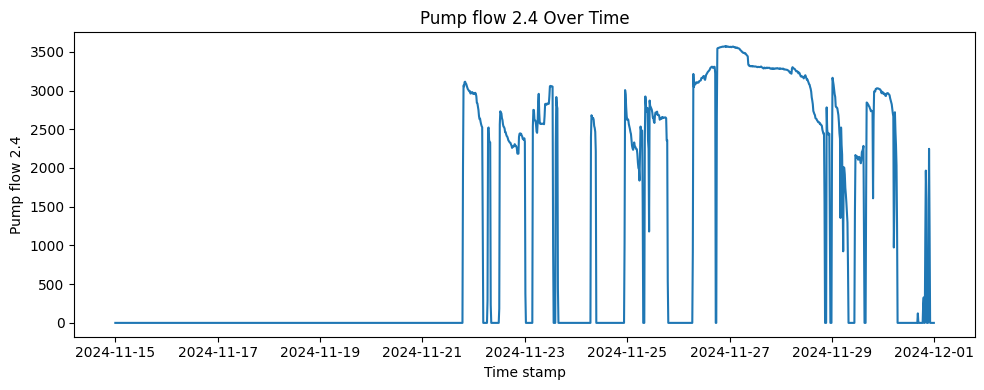

In [53]:
for col in flow_columns:
    print(col)
    plt.figure(figsize=(10, 4))
    plt.plot(df['Time stamp'], df[col])
    plt.title(f"{col} Over Time")
    plt.xlabel("Time stamp")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

Pump efficiency 1.1


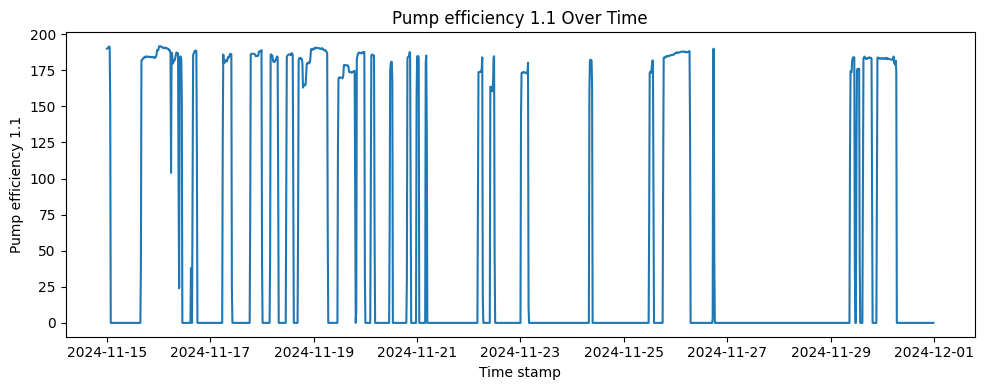

Pump efficiency 1.2


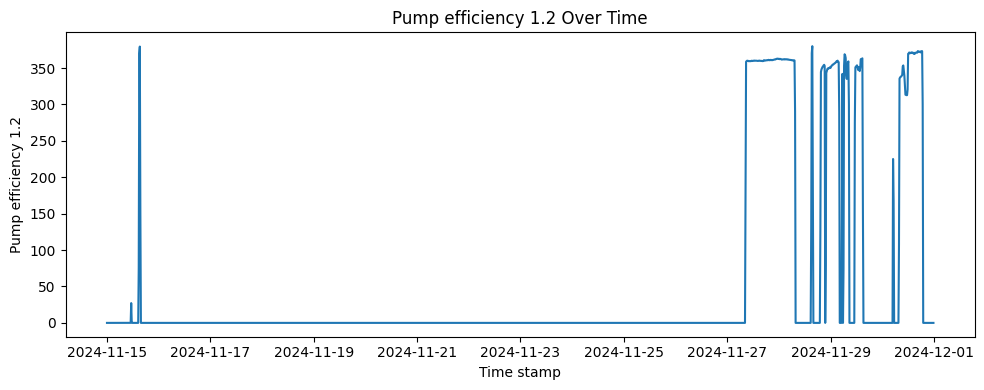

Pump efficiency 1.3


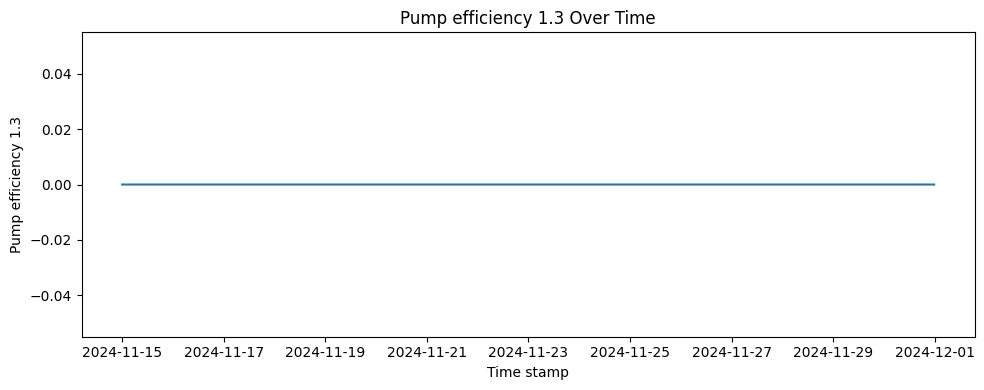

Pump efficiency 1.4


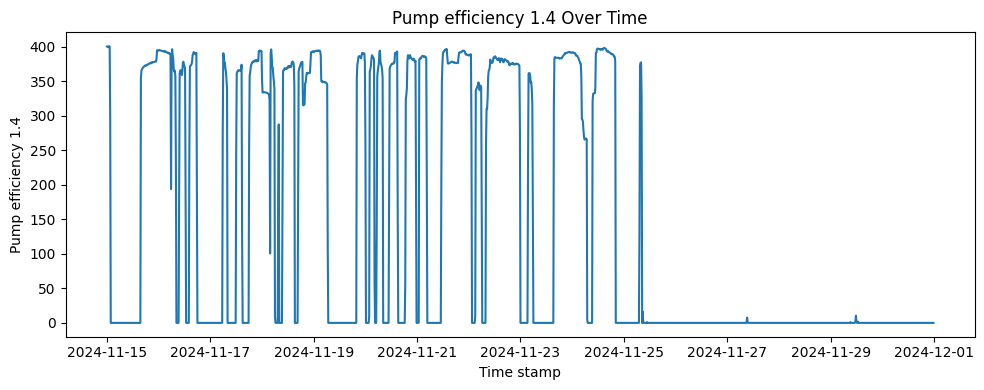

Pump efficiency 2.1


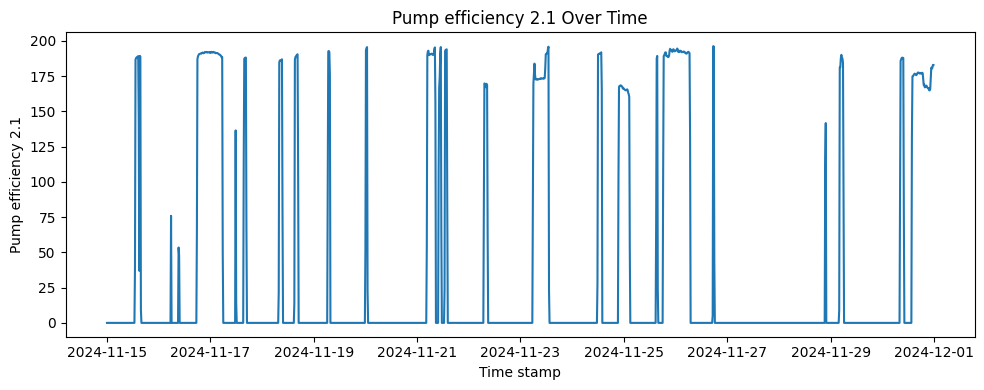

Pump efficiency 2.2


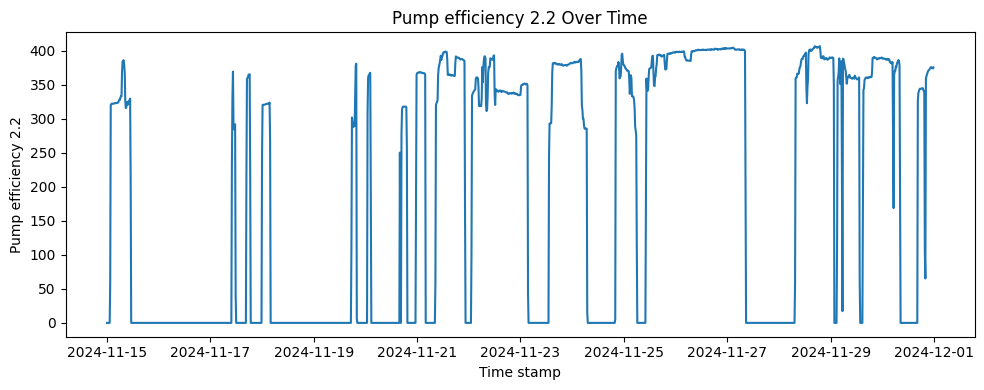

Pump efficiency 2.3


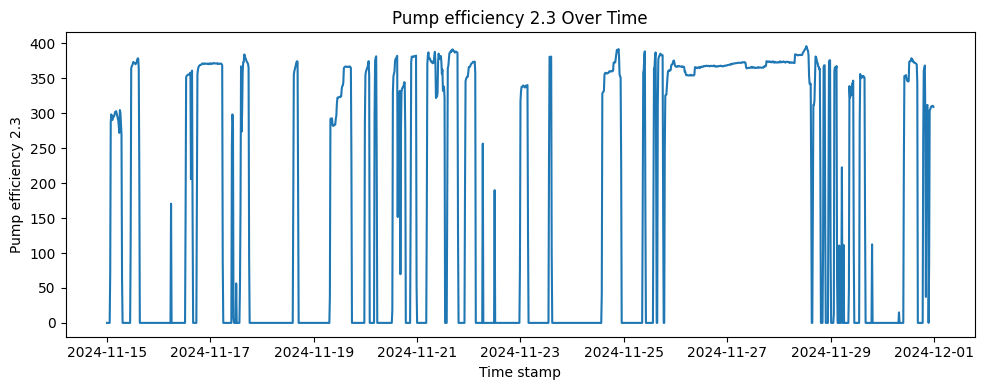

Pump efficiency 2.4


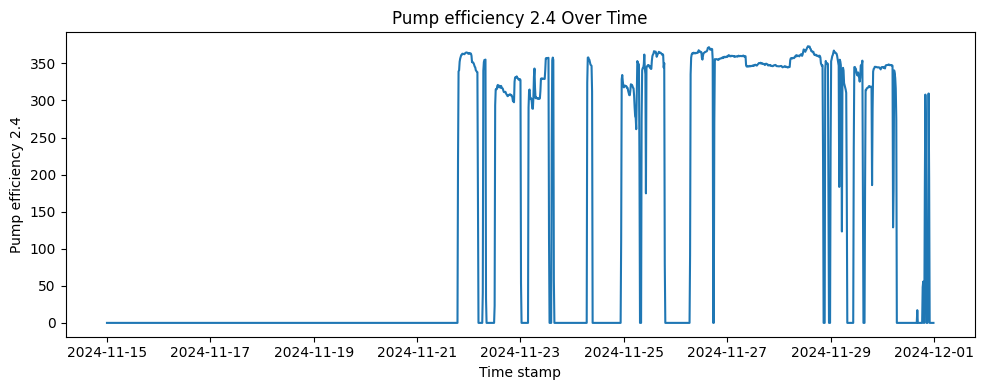

In [54]:
for col in efficiency_columns:
    print(col)
    plt.figure(figsize=(10, 4))
    plt.plot(df['Time stamp'], df[col])
    plt.title(f"{col} Over Time")
    plt.xlabel("Time stamp")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()


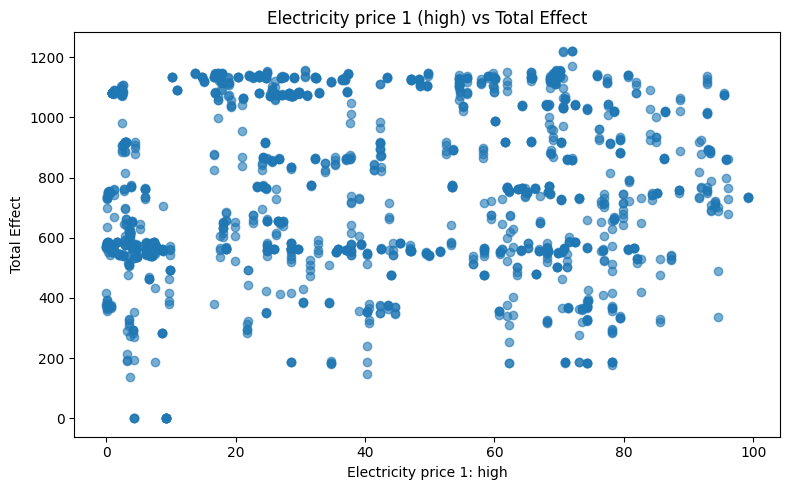

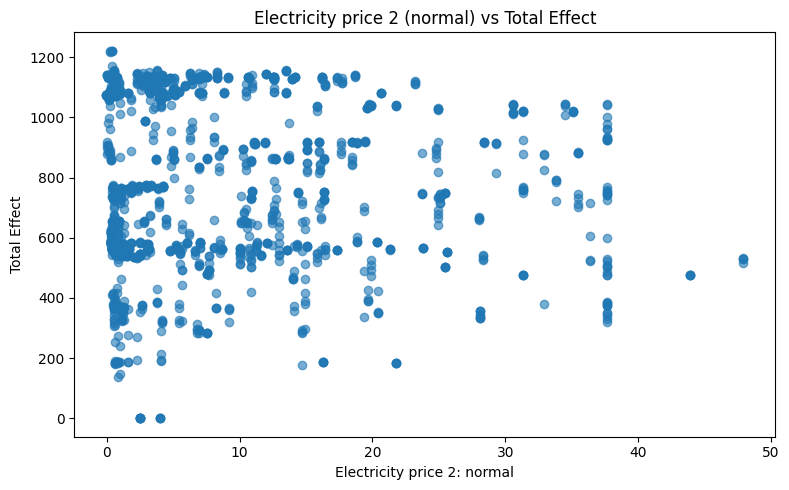

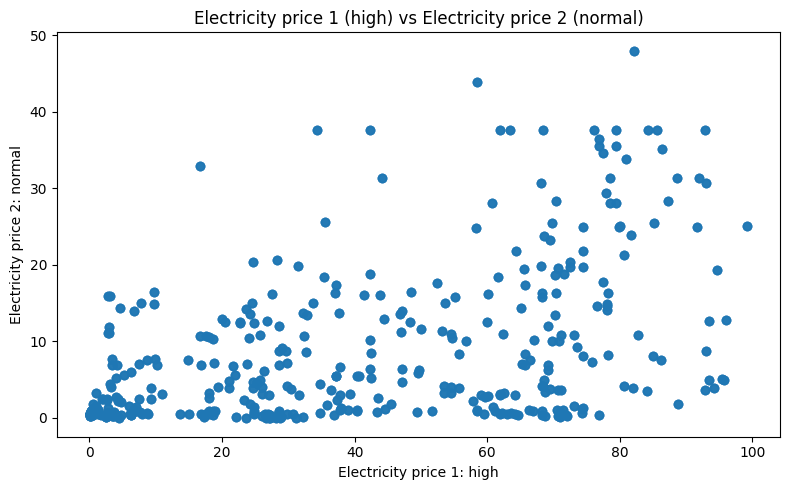

In [55]:

# Scatter plot: Electricity price 1 vs Total Effect
plt.figure(figsize=(8, 5))
plt.scatter(df['Electricity price 1: high'], df['Total Effect'], alpha=0.6)
plt.title('Electricity price 1 (high) vs Total Effect')
plt.xlabel('Electricity price 1: high')
plt.ylabel('Total Effect')
plt.tight_layout()
plt.show()

# Scatter plot: Electricity price 2 vs Total Effect
plt.figure(figsize=(8, 5))
plt.scatter(df['Electricity price 2: normal'], df['Total Effect'], alpha=0.6)
plt.title('Electricity price 2 (normal) vs Total Effect')
plt.xlabel('Electricity price 2: normal')
plt.ylabel('Total Effect')
plt.tight_layout()
plt.show()

# Scatter plot: Electricity price 1 vs Electricity price 2
plt.figure(figsize=(8, 5))
plt.scatter(df['Electricity price 1: high'], df['Electricity price 2: normal'], alpha=0.6)
plt.title('Electricity price 1 (high) vs Electricity price 2 (normal)')
plt.xlabel('Electricity price 1: high')
plt.ylabel('Electricity price 2: normal')
plt.tight_layout()
plt.show()




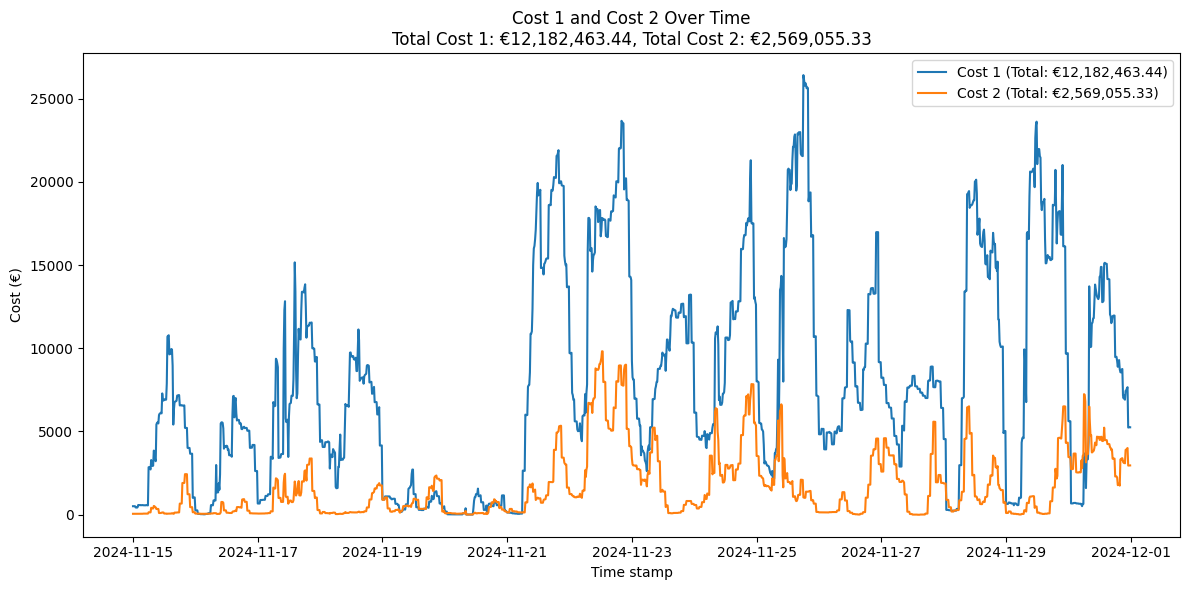

In [56]:
df['Cost 1'] = 0.25 * df['Electricity price 1: high'] * df['Total Effect']
df['Cost 2'] = 0.25 * df['Electricity price 2: normal'] * df['Total Effect']

total_cost_1 = df['Cost 1'].sum()
total_cost_2 = df['Cost 2'].sum()

plt.figure(figsize=(12, 6))
plt.plot(df['Time stamp'], df['Cost 1'], label=f"Cost 1 (Total: €{total_cost_1:,.2f})")
plt.plot(df['Time stamp'], df['Cost 2'], label=f"Cost 2 (Total: €{total_cost_2:,.2f})")
plt.title(f"Cost 1 and Cost 2 Over Time\nTotal Cost 1: €{total_cost_1:,.2f}, Total Cost 2: €{total_cost_2:,.2f}")
plt.xlabel("Time stamp")
plt.ylabel("Cost (€)")
plt.legend()
plt.tight_layout()
plt.show()


In [57]:
df.shape

(1536, 37)

In [17]:
start_time = 0

end_time = start_time + 96

future_electricity_prices=df['Electricity price 1: high'].iloc[start_time:end_time].values

future_electricity_prices

inflow_to_tunnel_f1=df['Inflow to tunnel F1'].iloc[start_time:end_time].values

inflow_to_tunnel_f1


# This will be for more detailed data in the future:
#df_subset = df.iloc[start_time:end_time].copy()

# We have 6 large pumps and 2 small pumps.
# As a first approximation, the small pumps are 200kW and the large ones are 400kW.
# Thus a small one is one "quantum" and a large one is two quanta.
total_quanta_in_pumping=6*2+2*1

initial_water_level=df['Water level in tunnel L2'].iloc[start_time]
initial_volume=df['Water volume in tunnel V'].iloc[start_time]

# In the first approximation, we assume that the pumps always run at full power.
# And that they suck a certain amount of water per quantum.

pump_flow_per_quantum=16000/5/2

total_inflow_in_next_24_hours=df['Inflow to tunnel F1'].iloc[start_time:end_time].sum()

total_inflow_in_next_24_hours




np.float64(97178.63220214844)

In [18]:
volume_at_end_if_no_pumping=initial_volume+total_inflow_in_next_24_hours
height_at_end_if_no_pumping=tunnel_height_from_volume(volume_at_end_if_no_pumping)
height_at_end_if_no_pumping

7.037040780362217

(np.float64(3.1260000000000003), np.float64(3.1260000000000003))

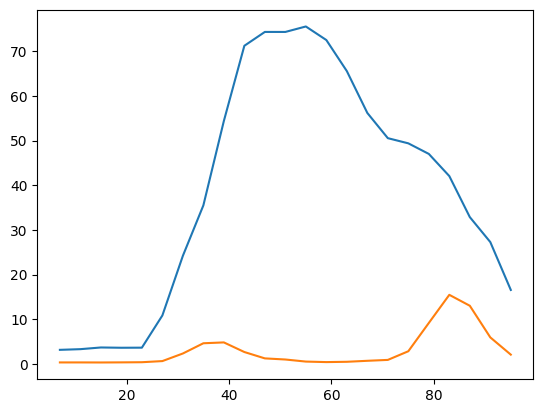

In [19]:
electricity_price_running_mean_2h_1=df['Electricity price 1: high'].iloc[start_time:end_time].rolling(window=8).mean()
electricity_price_running_mean_2h_2=df['Electricity price 2: normal'].iloc[start_time:end_time].rolling(window=8).mean()

plt.plot(electricity_price_running_mean_2h_1)
plt.plot(electricity_price_running_mean_2h_2)

electricity_price_running_mean_2h_1[7],future_electricity_prices[0:8].mean()


In [20]:
min_value = np.min(electricity_price_running_mean_2h_1)
min_index = np.argmin(electricity_price_running_mean_2h_1)

min_value,min_index

suction_during_2h_5_pumps_blasting=pump_flow_per_quantum*5*2
inflow_during_first_2h=inflow_to_tunnel_f1[0:8].sum()

volume_after_2h_of_blasting=initial_volume+inflow_during_first_2h-suction_during_2h_5_pumps_blasting
height_after_2h_of_blasting=tunnel_height_from_volume(volume_after_2h_of_blasting)

suction_during_2h_5_pumps_blasting, initial_volume, inflow_during_first_2h, volume_after_2h_of_blasting, height_after_2h_of_blasting



(16000.0,
 np.float64(10064.9892578125),
 np.float64(10946.888427734375),
 np.float64(5011.877685546875),
 1.7655588871296406)

In [21]:
total_inflow_in_next_24_hours/pump_flow_per_quantum

np.float64(60.73664512634277)

In [22]:

#for i in np.arange(1,pumping_strategies.shape[0]):
#    for j in np.arange(pumping_strategies.shape[1]):
#        water_levels[i,i,j]=water_levels[i-1,i,j] \
#        +inflow_to_tunnel_f1[i] \
#        - 0.25 * ( pumping_strategies[i,j] + 1) *pump_flow_per_quantum # Always minimum one pump, hence plus 1

#        pumping_costs[i,i,j]=0.25*future_electricity_prices[i]*j

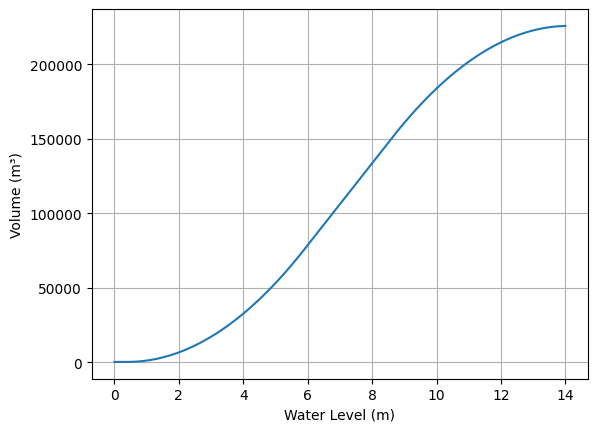

10.200000000000001 187825.00000000003


In [23]:
# generate h values
h_vals = np.arange(0, 14.1, 0.1)

# compute volumes
volumes = [tunnel_volume(h) for h in h_vals]

# plot
plt.plot(h_vals, volumes)
plt.xlabel("Water Level (m)")
plt.ylabel("Volume (m³)")
plt.grid(True)
plt.show()

print(h_vals[102],volumes[102])

In [ ]:

def optimize_pumps_MPC_step(
    V0,
    inflow_forecast,       # shape (N,)
    price_forecast,        # shape (N,)
    dt,
    c_flow_per_kW,
    V_min,
    V_max,
    P_min,
    P_max,
    ramp_limit=None,
):
    N = len(inflow_forecast)
    
    # Decision variables
    P = cp.Variable(N)          # power [kW]
    V = cp.Variable(N + 1)      # volume [m³]
    
    constraints = []
    
    # Initial condition
    constraints.append(V[0] == V0)
    
    # Dynamics and bounds
    for t in range(N):
        constraints.append(
            V[t+1] == V[t] + (inflow_forecast[t] - c_flow_per_kW * P[t] * dt)
        )
        constraints.append(P[t] >= P_min)
        constraints.append(P[t] <= P_max)
    
    for t in range(N + 1):
        constraints.append(V[t] >= V_min)
        constraints.append(V[t] <= V_max)
    
    # Optional ramp constraints
    if ramp_limit is not None:
        for t in range(N-1):
            constraints.append(P[t+1] - P[t] <= ramp_limit)
            constraints.append(P[t] - P[t+1] <= ramp_limit)
    
    # Objective: minimize energy cost
    cost = cp.sum(price_forecast * P) * dt
    problem = cp.Problem(cp.Minimize(cost), constraints)
    problem.solve(solver=cp.ECOS)  # or GUROBI / OSQP / whatever
    
    if problem.status not in ["optimal", "optimal_inaccurate"]:
        raise RuntimeError("Optimization failed, status: " + problem.status)
    
    return P.value, V.value


In [35]:
current_volume=initial_volume
inflow_next_N=inflow_to_tunnel_f1
price_next_N=future_electricity_prices
c=2400/400
V_min=0
V_max=225850
P_min=200
P_max=2800
some_value=3200

In [36]:
P_star, V_star = optimize_pumps_MPC_step(
    V0=initial_volume,
    inflow_forecast=inflow_next_N,
    price_forecast=price_next_N,
    dt=0.25,
    c_flow_per_kW=c,
    V_min=V_min,
    V_max=V_max,
    P_min=P_min,
    P_max=P_max,
    ramp_limit=some_value,
)

P_to_apply_now = P_star[0]


c:\Users\Svante\Hacking\valmet_HSY_sewage\intelligent_flow\Lib\site-packages\cvxpy\expressions\expression.py:683: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 5 times so far.

  warnings.warn(msg, UserWarning)


In [37]:
P_to_apply_now

np.float64(200.00000167185274)

In [40]:
import cvxpy as cp

def optimize_pumps_MPC_step(
    V0,
    inflow_forecast,       # shape (N,)
    price_forecast,        # shape (N,)
    dt,
    c_flow_per_kW,
    V_min,
    V_max,
    P_min,
    P_max,
    ramp_limit=None,
    V_target_daily=375.0,  # target volume to reach at least once
):
    N = len(inflow_forecast)
    
    # Decision variables
    P = cp.Variable(N)          # power [kW]
    V = cp.Variable(N + 1)      # volume [m³]
    
    constraints = []
    
    # Initial condition
    constraints.append(V[0] == V0)
    
    # Dynamics and bounds
    for t in range(N):
        # YOU HAD A UNIT BUG HERE:
        # Should be (inflow - c*P) * dt, not (inflow - c*P*dt)
        constraints.append(
            V[t+1] == V[t] + (inflow_forecast[t] - c_flow_per_kW * P[t]) * dt
        )
        constraints.append(P[t] >= P_min)
        constraints.append(P[t] <= P_max)
    
    for t in range(N + 1):
        constraints.append(V[t] >= V_min)
        constraints.append(V[t] <= V_max)
    
    # Daily "flush" constraint: at horizon end, must be low enough
    constraints.append(V[N] <= V_target_daily)
    
    # Optional ramp constraints
    if ramp_limit is not None:
        for t in range(N-1):
            constraints.append(P[t+1] - P[t] <= ramp_limit)
            constraints.append(P[t] - P[t+1] <= ramp_limit)
    
    # Objective: minimize energy cost
    cost = cp.sum(price_forecast * P) * dt
    problem = cp.Problem(cp.Minimize(cost), constraints)
    problem.solve(solver=cp.ECOS)  # or OSQP / SCS
    
    if problem.status not in ["optimal", "optimal_inaccurate"]:
        raise RuntimeError("Optimization failed, status: " + problem.status)
    
    return P.value, V.value


In [41]:
current_volume=initial_volume
inflow_next_N=inflow_to_tunnel_f1
price_next_N=future_electricity_prices
c=2400/400
V_min=0
V_max=225850
P_min=200
P_max=2800
some_value=3200
V_target_daily=375.0




In [42]:
P_star, V_star = optimize_pumps_MPC_step(
    V0=initial_volume,
    inflow_forecast=inflow_next_N,
    price_forecast=price_next_N,
    dt=0.25,
    c_flow_per_kW=c,
    V_min=V_min,
    V_max=V_max,
    V_target_daily=V_target_daily,
    P_min=P_min,
    P_max=P_max,
    ramp_limit=some_value,
)

P_to_apply_now = P_star[0]

c:\Users\Svante\Hacking\valmet_HSY_sewage\intelligent_flow\Lib\site-packages\cvxpy\expressions\expression.py:683: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 6 times so far.

  warnings.warn(msg, UserWarning)


In [43]:
P_to_apply_now


np.float64(200.00000384535383)